In [1]:
import pandas as pd
import numpy as np
import random
from re import compile

import maxminddb
from datetime import datetime as dt
from user_agents import parse
from crawlerdetect import CrawlerDetect

import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
# Global settings
pd.set_option("display.max_colwidth", 200)
random.seed(2291)
np.random.seed(2291)

In [3]:
# Form dataset from Apache access.log
file_log = "input/access.log"  # Source: https://github.com/elastic/examples/tree/master/Common%20Data%20Formats/apache_logs
file_csv = "input/access.csv"
file_ipinfo = "input/country.mmdb"  # Source: https://ipinfo.io/products/free-ip-database
list_log = []

# Parse access.log with regex
pattern = r'(?P<ip>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) (?P<client>.*?) (?P<user>.*?) \[(?P<datetime>.*?)\] "(?P<method>\w+) (?P<url>.*?) (?P<protocol>HTTP/1.\d)" (?P<status>\d+) (?P<size>\d+) "(?P<referrer>.*?)" "(?P<agent>.*?)"'
regex = compile(pattern)
reader = maxminddb.open_database(file_ipinfo)
with open(file_log, "r") as fin:
    for line in fin:
        match = regex.match(line)
        if not match:  # If cannot parse the line
            continue

        # Get country by IP
        ip = match.group("ip")
        country = reader.get(ip)["country_name"]

        # Get time/date
        datetime_str = match.group("datetime")
        datetime_obj = dt.strptime(datetime_str, '%d/%b/%Y:%H:%M:%S %z')
        date = datetime_obj.date()
        time = datetime_obj.time()

        # Retrieve OS from User-Agent
        agent = match.group("agent")
        os = parse(agent).os.family

        list_log.append({
            "IP": ip,
            "Country": country,

            # "Client": match.group("client"),
            # "User": match.group("user"),

            "Date": date,
            "Time": time,

            "Method": match.group("method"),
            "URL": match.group("url"),
            # "Protocol": match.group("protocol"),

            "Status": match.group("status"),
            "Size": match.group("size"),

            "Referrer": match.group("referrer"),
            "User-Agent": agent,
            "OS": os
        })

# Save parsed access.log as CSV
df = pd.DataFrame(list_log)
df.to_csv(file_csv, index = False)
print(f"Number of entries: {len(df)}")

Number of entries: 9330


In [4]:
# Load dataset
df = pd.read_csv(file_csv, encoding = "latin-1")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9330 entries, 0 to 9329
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   IP          9330 non-null   object
 1   Country     9330 non-null   object
 2   Date        9330 non-null   object
 3   Time        9330 non-null   object
 4   Method      9330 non-null   object
 5   URL         9330 non-null   object
 6   Status      9330 non-null   int64 
 7   Size        9330 non-null   int64 
 8   Referrer    9330 non-null   object
 9   User-Agent  9330 non-null   object
 10  OS          9330 non-null   object
dtypes: int64(2), object(9)
memory usage: 801.9+ KB


,IP,Country,Date,Time,Method,URL,Status,Size,Referrer,User-Agent,OS
0,83.149.9.216,Russia,2015-05-17,10:05:03,GET,/presentations/logstash-monitorama-2013/images/kibana-search.png,200,203023,http://semicomplete.com/presentations/logstash-monitorama-2013/,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36",Mac OS X
1,83.149.9.216,Russia,2015-05-17,10:05:43,GET,/presentations/logstash-monitorama-2013/images/kibana-dashboard3.png,200,171717,http://semicomplete.com/presentations/logstash-monitorama-2013/,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36",Mac OS X
2,83.149.9.216,Russia,2015-05-17,10:05:47,GET,/presentations/logstash-monitorama-2013/plugin/highlight/highlight.js,200,26185,http://semicomplete.com/presentations/logstash-monitorama-2013/,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36",Mac OS X
3,83.149.9.216,Russia,2015-05-17,10:05:12,GET,/presentations/logstash-monitorama-2013/plugin/zoom-js/zoom.js,200,7697,http://semicomplete.com/presentations/logstash-monitorama-2013/,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36",Mac OS X
4,83.149.9.216,Russia,2015-05-17,10:05:07,GET,/presentations/logstash-monitorama-2013/plugin/notes/notes.js,200,2892,http://semicomplete.com/presentations/logstash-monitorama-2013/,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36",Mac OS X


In [5]:
# A) Count users by day
users_by_day = df.groupby("Date")["IP"].nunique()
users_by_day = users_by_day.reset_index().rename(columns = {"IP": "Unique Users"})
users_by_day.to_csv("output/A_users_by_day.csv", index = False)
display(users_by_day)

,Date,Unique Users
0,2015-05-17,325
1,2015-05-18,584
2,2015-05-19,526
3,2015-05-20,478


In [6]:
# B) Sort user agents by users
top_user_agents = df.groupby("User-Agent")["IP"].nunique().sort_values(ascending = False)
top_user_agents = top_user_agents.reset_index().rename(columns = {"IP": "Unique Users"})
top_user_agents.to_csv("output/B_top_user_agents.csv", index = False)
display(top_user_agents)

,User-Agent,Unique Users
0,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36",103
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:22.0) Gecko/20100101 Firefox/22.0,80
2,Mozilla/5.0 (compatible; Baiduspider/2.0; +http://www.baidu.com/search/spider.html),73
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:21.0) Gecko/20100101 Firefox/21.0,65
4,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:27.0) Gecko/20100101 Firefox/27.0,59
...,...,...
537,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36",1
538,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.71 (KHTML, like Gecko) Version/6.1 Safari/537.71",1
539,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/536.26.17 (KHTML, like Gecko) Version/6.0.2 Safari/536.26.17",1
540,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_4) AppleWebKit/536.11 (KHTML, like Gecko) Chrome/20.0.1132.47 Safari/536.11",1


In [7]:
# C) Sort OS by users
top_os = df.groupby("OS")["IP"].nunique().sort_values(ascending = False)
top_os = top_os.reset_index().rename(columns = {"IP": "Unique Users"})
top_os.to_csv("output/C_top_os.csv", index = False)
display(top_os)

,OS,Unique Users
0,Windows,559
1,Other,336
2,Mac OS X,303
3,Linux,252
4,Ubuntu,106
5,Android,83
6,iOS,55
7,Chrome OS,2
8,NetBSD,2
9,CentOS,1


In [8]:
# D) Sort country by users
top_country = df.groupby("Country")["IP"].nunique().sort_values(ascending = False)
top_country = top_country.reset_index().rename(columns = {"IP": "Unique Users"})
top_country.to_csv("output/D_top_countries.csv", index = False)
display(top_country)

,Country,Unique Users
0,United States,559
1,China,107
2,Germany,102
3,France,85
4,United Kingdom,65
...,...,...
89,Luxembourg,1
90,Montenegro,1
91,Pakistan,1
92,Oman,1


In [9]:
# E) Select search bots
def get_bot_name(agent):
    bot_name = ""
    crawler_detect = CrawlerDetect()
    if crawler_detect.isCrawler(agent):  # Check if user agent is a bot
        bot_name = crawler_detect.getMatches()  # Get the name of the bot
        if not bot_name:
            bot_name = "Unknown"
    return bot_name

search_bots = df.copy(deep = True)
search_bots["Bot Name"] = search_bots["User-Agent"].apply(get_bot_name)
search_bots = search_bots[search_bots["Bot Name"] != ""]
search_bots = search_bots.groupby("Bot Name")["IP"].nunique().sort_values(ascending = False)
search_bots = search_bots.reset_index().rename(columns = {"IP": "Unique Users"})
search_bots.to_csv("output/E_search_bots.csv", index = False)
display(search_bots)

,Bot Name,Unique Users
0,Baiduspider,74
1,bingbot,32
2,FeedBurner,28
3,Digg,18
4,facebookexternalhit,13
...,...,...
62,Mojeek,1
63,Python-urllib,1
64,Reeder/,1
65,Robosourcer,1


Found 45 anomalies


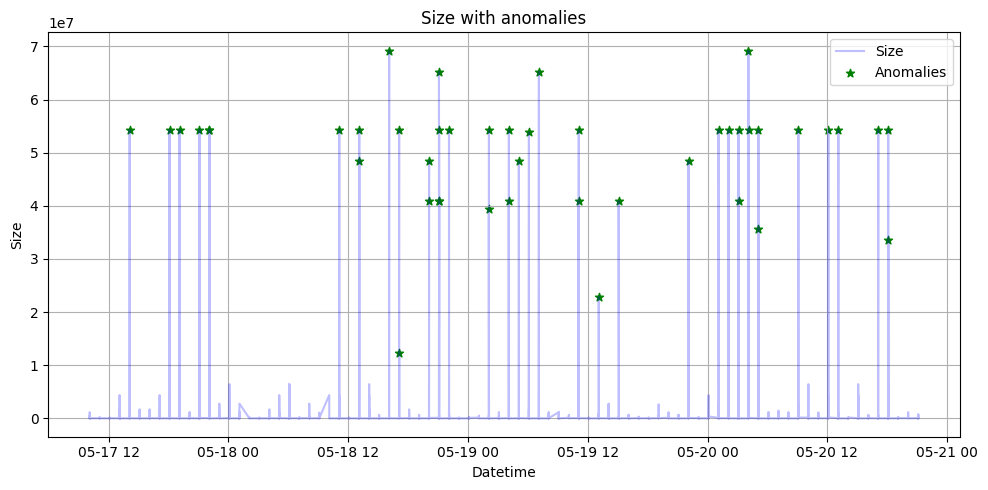

In [10]:
# F) Detect anomalies
# Get datetime objects from separated date & time
datetime = pd.to_datetime(df["Date"] + " " + df["Time"], format = "%Y-%m-%d %H:%M:%S")

# Calculate Z-score for numerical features
cols = ["Size"]  # Status can be added
for col in cols:
    df_zscore = df[[col]].apply(zscore)
    threshold = 3  # Z-score that won"t be treated as anomaly is in range [-3; 3]
    anomalies = df[(df_zscore > threshold).any(axis = 1)]
    anomalies.to_csv(f"output/F_{col}_anomalies.csv", index = False)
    print(f"Found {len(anomalies)} anomalies")

    # Plot anomalies
    plt.figure(figsize = (10, 5))
    plt.plot(datetime, df[col], label = col, color = "blue", alpha = 0.25)
    plt.scatter(datetime[anomalies.index], anomalies[col], color = "green", label = "Anomalies", marker = "*")
    plt.title(f"{col} with anomalies")
    plt.xlabel("Datetime")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()